# Loading Necessary Libraries

In [28]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
import argparse
from imutils import paths
import numpy as np
import cv2
import os
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense, Dropout
from keras import backend as K
from keras.layers import MaxPooling2D

# Function to find greatest contour

In [29]:
def find_biggest_contour(image):
    image = image.copy()
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    biggest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros(image.shape, np.uint8)
    cv2.drawContours(mask, [biggest_contour], -1, 255, -1)
    return biggest_contour, mask
def overlay_mask(mask, image):
    rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.addWeighted(rgb_mask, 0.5, image, 0.5, 0)

In [30]:
#reading image paths
image_paths = list(paths.list_images("CNN/"))
#print(image_paths)

#creating empty lists for storing image data and corresponding labels
data = []
labels = []

for (i, image_path) in enumerate(image_paths):
    image = cv2.imread(image_path) #reading image
    
    try:
        label = image_path.split(os.path.sep)[-2] #reading the label

        image_blur = cv2.GaussianBlur(image, (7, 7), 0) #blurring the image
        
        image_blur_hsv = cv2.cvtColor(image_blur, cv2.COLOR_RGB2HSV) #converting the image into HSV color space
        
        min_red = np.array([80, 60, 140])
        max_red = np.array([255, 255, 255])
        image_red1 = cv2.inRange(image_blur_hsv, min_red, max_red) #creating a red image with thresholds
        
        big_contour, mask = find_biggest_contour(image_red1) #finding the greatest contour
        
        (x, y), radius = cv2.minEnclosingCircle(big_contour) #taking the center and radius of a circle enclosing the biggest contour
        center = (int(x), int(y)) 
        radius = int(radius)
        
        imCircle = image.copy()
        cv2.circle(imCircle, center, radius, (0, 255, 0), 1) #drawing the circle around the big contour
        
        #code to crop the image around the detected nucleus
        height, width, channels = imCircle.shape
        border = [0, 0, 0, 0]
        if center[0] + radius > width:
            extera = (center[0] + radius) - width
            border[3] = extera + 1

        if (center[0] - radius < 0):
            extera = width - (center[0] + radius)
            border[2] = extera + 1

        if center[1] + radius > height:
            extera = (center[1] + radius) - height
            border[1] = extera + 1

        if center[1] + radius < 0:
            extera = height - (center[1] + radius)
            border[0] = extera + 1

        y = center[1] - radius
        if y < 0:
            y = 0
        y2 = center[1] + radius
        x = center[0] - radius
        if x < 0:
            x = 0

        x2 = center[0] + radius

        cropped_image = image[y:y2, x:x2]
        
        image = cv2.resize(cropped_image, (50,50), interpolation = cv2.INTER_AREA) #taking a 50X50 cropped image
        image=img_to_array(image, data_format=None)
        
        data.append(image) #storing the image data in the list
        labels.append(label) #storing the labels in the list
        
    except Exception as a:
            print("preprocessor", a)

preprocessor OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [31]:
(data, labels) = np.array(data), np.array(labels)

In [32]:
print(labels.shape)

(12514,)


In [33]:
print(data.shape)

(12514, 50, 50, 3)


In [34]:
print(label[1])

E


In [35]:
data = data.astype("float") / 255.0
(train_x, test_x, train_y, test_y) = train_test_split(data, labels, test_size=0.25, random_state=42)
train_y = LabelBinarizer().fit_transform(train_y)
test_y = LabelBinarizer().fit_transform(test_y)

In [36]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(9385, 50, 50, 3)
(9385, 4)
(3129, 50, 50, 3)
(3129, 4)


In [37]:
print("[INFO] compiling model...")
opt = SGD(lr=0.025)
classes=4

model = Sequential()
input_shape = (50, 50, 3)
if K.image_data_format() == "channels_first":
    input_shape = (3, 50, 50)
# model.add(Dropout(0.2,input_shape=inputShape))
model.add(Conv2D(size, (3, 3), padding="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(size, (3, 3), padding="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(size, (3, 3), padding="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.5))

model.add(Conv2D(size, (3, 3), padding="same", input_shape=input_shape))
model.add(Activation("relu"))

model.add(Flatten())
model.add(Activation("relu"))

model.add(Dense(classes))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


[INFO] compiling model...


In [38]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 50, 50, 50)        1400      
_________________________________________________________________
activation_6 (Activation)    (None, 50, 50, 50)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 50)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 50)        22550     
_________________________________________________________________
activation_7 (Activation)    (None, 16, 16, 50)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 50)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 50)         

In [39]:
print("[INFO] training network...")
h = model.fit(train_x, train_y, validation_split=0.1, batch_size=50, epochs=100, verbose=1)

[INFO] training network...
Epoch 1/100
169/169 [==============================] - 25s 151ms/step - loss: 1.3852 - accuracy: 0.2503 - val_loss: 1.3809 - val_accuracy: 0.3578
Epoch 2/100
169/169 [==============================] - 24s 142ms/step - loss: 1.3785 - accuracy: 0.3016 - val_loss: 1.3696 - val_accuracy: 0.3876
Epoch 3/100
169/169 [==============================] - 22s 132ms/step - loss: 1.3591 - accuracy: 0.3584 - val_loss: 1.3192 - val_accuracy: 0.4803
Epoch 4/100
169/169 [==============================] - 22s 133ms/step - loss: 1.2626 - accuracy: 0.3983 - val_loss: 1.1081 - val_accuracy: 0.4846
Epoch 5/100
169/169 [==============================] - 27s 161ms/step - loss: 1.1312 - accuracy: 0.4531 - val_loss: 0.9528 - val_accuracy: 0.5687
Epoch 6/100
169/169 [==============================] - 31s 186ms/step - loss: 1.0364 - accuracy: 0.4890 - val_loss: 1.0064 - val_accuracy: 0.4803
Epoch 7/100
169/169 [==============================] - 29s 171ms/step - loss: 0.9780 - accuracy: 

169/169 [==============================] - 22s 133ms/step - loss: 0.2663 - accuracy: 0.8933 - val_loss: 0.2001 - val_accuracy: 0.9169
Epoch 57/100
169/169 [==============================] - 22s 129ms/step - loss: 0.2580 - accuracy: 0.8960 - val_loss: 0.2113 - val_accuracy: 0.9233
Epoch 58/100
169/169 [==============================] - 22s 131ms/step - loss: 0.2532 - accuracy: 0.8995 - val_loss: 0.1947 - val_accuracy: 0.9169
Epoch 59/100
169/169 [==============================] - 22s 130ms/step - loss: 0.2629 - accuracy: 0.8970 - val_loss: 0.2172 - val_accuracy: 0.9042
Epoch 60/100
169/169 [==============================] - 22s 130ms/step - loss: 0.2509 - accuracy: 0.8975 - val_loss: 0.1778 - val_accuracy: 0.9233
Epoch 61/100
169/169 [==============================] - 22s 130ms/step - loss: 0.2399 - accuracy: 0.9026 - val_loss: 0.2032 - val_accuracy: 0.9137
Epoch 62/100
169/169 [==============================] - 22s 131ms/step - loss: 0.2177 - accuracy: 0.9123 - val_loss: 0.1820 - val_a

In [19]:
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=size)
print(classification_report(test_y.argmax(axis=1), predictions.argmax(axis=1), 
                            target_names=["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]))



[INFO] evaluating network...
              precision    recall  f1-score   support

  EOSINOPHIL       0.86      0.97      0.91       804
  LYMPHOCYTE       0.99      1.00      0.99       769
    MONOCYTE       0.99      0.99      0.99       797
  NEUTROPHIL       0.96      0.83      0.89       759

    accuracy                           0.95      3129
   macro avg       0.95      0.95      0.95      3129
weighted avg       0.95      0.95      0.95      3129



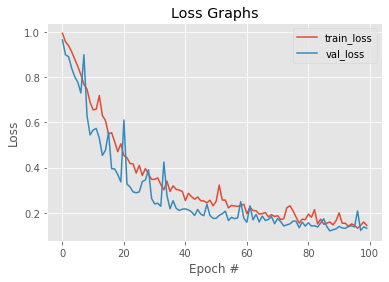

In [21]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, ep), h.history["loss"], label="train_loss")
plt.plot(np.arange(0, ep), h.history["val_loss"], label="val_loss")
plt.title("Loss Graphs")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

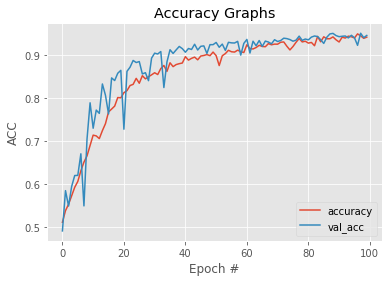

In [22]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, ep), h.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, ep), h.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Graphs")
plt.xlabel("Epoch #")
plt.ylabel("ACC")
plt.legend()
plt.show()

In [ ]:
# input_dir = 'Training data3/train/data'
# ref_dir = 'Training data3/train/ref'
# X,Y,QRS = loaddata2(input_dir, ref_dir)
# X_rev = X * -1
# X = np.concatenate((X,X_rev), axis=-1)
# #x_train, x_test, y_train, y_test, QRS_train, QRS_test = train_test_split(X, Y, QRS, test_size=0.20, random_state=7)
# # K-Folds
# flods = 5
# # fold for pre-test. range: 0:flods-1
# selected_flod = 1

# #--------------------------------------------------------------------------
# # K-fold cross validation test harness
# #--------------------------------------------------------------------------
# if _name_ == '_main_':
#     print('Cross validating...')
#     kfold = KFold(n_splits=flods, shuffle = True, random_state = 7)
#     cvscores_dnn = []

#     fold_id = -1
#     for train, test in kfold.split(X):

#         # only run the selected fold
#         fold_id+=1
# #         if fold_id != selected_flod:
# #             continue
#         x_train = X[train]
#         y_train = Y[train]
#         x_test =  X[test]
#         y_test =  Y[test]
#         QRS_test = itemgetter(*test)(QRS)
#         # load model
#         model_structure_file = 'model_unet_lstm2_unique_shuffle_2channel_newdata3_segment_MITDB_pretrain_10s_10early_4s_Score.json'
#         model_weights_file = 'best_unet_lstm2_unique_shuffle_2channel_2000_newdata3_model_segment_MITDB_pretrain_10s_10early_4s_Score_'+str(fold_id)+'.model'

#         json_file = open(model_structure_file, 'r')  
#         loaded_model_json = json_file.read()  
#         json_file.close()  
#         model = model_from_json(loaded_model_json)
#         model.load_weights(model_weights_file)
#         print('#########################')
#         for i in range(1,10):
#             mean_score = score_model(model, x_test, QRS_test, i/10.0)
#             print('%f: %f' % (i/10.0, mean_score))